In [1]:
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import scipy as sc
from statsmodels.stats.multitest import fdrcorrection
import warnings
warnings.filterwarnings("ignore")

plt.style.use('./plot_script/mplstyle_czi')
import sys
sys.path.insert(0, './plot_script/')
import cziplot
dpi=150

In [2]:
# meta data
cluster_meta=pd.read_csv('../data/TableS7-cell_metadata.csv.gz',index_col=0).dropna()
cluster_meta['age']=cluster_meta['donor'].str[0]
cluster_meta['sex']=cluster_meta['donor'].str[1]
print(cluster_meta.shape)
gene_meta=pd.read_csv('../data/gencode.v37.annotation.intragenic.bed.gz',
                      names=['chr','start','end','gene_id','strand','tmp','gene_name','fn'],
                      index_col='gene_id', sep='\t')
gene_meta['len']=gene_meta['end']-gene_meta['start']
gene_meta=gene_meta[~gene_meta['chr'].isin(['chrY','chrM'])]
genedict_nametoid=dict(zip(gene_meta.gene_name, gene_meta.index))
genedict_idtoname=dict(zip(gene_meta.index, gene_meta.gene_name))
level2_order=cziplot.level2_order
level2_palette=cziplot.level2_palette

(54779, 22)


In [3]:
# DMR
df_dmrs=pd.read_csv('../data/ageDMRall.tsv.gz',sep='\t')

# DEs
fcthres=np.log2(1.2)
pthres=0.05

fulldata=pd.read_csv('../data/ageDEall.tsv.gz',sep='\t',index_col=0)
fulldata=fulldata[fulldata['celltype'].isin(cziplot.level2_order)]
fulldata=fulldata.join(gene_meta[['chr','start','end','strand']])
data=fulldata[(fulldata['adj.P.Val']<pthres) & (np.abs(fulldata['logFC'])>fcthres)]
data

,gene_name,logFC,AveExpr,P.Value,adj.P.Val,celltype,chr,start,end,strand
ENSG00000003402.20,CFLAR,2.493147,1.929680,0.000038,0.020989,L6CT_TLE4_FAM95C,chr2,201116154,201176687,+
ENSG00000004660.15,CAMKK1,1.072395,4.340857,0.000159,0.023660,L6IT_THEMIS_LINC00343,chr17,3860315,3894891,-
ENSG00000004660.15,CAMKK1,1.125495,4.559393,0.000857,0.039737,L4-5IT_RORB_TSHZ2,chr17,3860315,3894891,-
ENSG00000004700.16,RECQL,-0.774865,4.503595,0.000654,0.046767,L6IT_THEMIS_LINC00343,chr12,21468910,21501669,-
ENSG00000005379.17,TSPOAP1,0.883857,4.229286,0.000978,0.041793,MGE_PVALB,chr17,58301228,58328795,-
...,...,...,...,...,...,...,...,...,...,...
ENSG00000288529.1,AL035699.1,-0.578092,3.143564,0.000985,0.029796,L2-4IT_CUX2,chr6,133953304,133980088,+
ENSG00000288569.1,LINC01949,1.820579,2.300226,0.000040,0.036358,CGE_VIP,chr5,87205408,87240145,-
ENSG00000288605.1,AC007461.1,1.453317,2.841321,0.000056,0.037909,CGE_VIP,chr17,72033772,72220948,-
ENSG00000288612.1,AL133351.4,1.522576,3.842918,0.001219,0.046729,MGE_PVALB,chr6,3023472,3027426,+


# methylation around age-DEGs

In [4]:
! gdown -O /scratch/binc_TSSbins_AgeDEGs_CelltypesDonors_binsize1kb.tsv.gz  https://drive.google.com/file/d/1zpEGYWywhh6-ZJgjQoKTfYQJ6jpDYnO4/view?usp=drive_link --fuzzy

Downloading...
From (original): https://drive.google.com/uc?id=1zpEGYWywhh6-ZJgjQoKTfYQJ6jpDYnO4
From (redirected): https://drive.google.com/uc?id=1zpEGYWywhh6-ZJgjQoKTfYQJ6jpDYnO4&confirm=t&uuid=891fcd69-018c-4eba-9c19-a0669769e394
To: /scratch/binc_TSSbins_AgeDEGs_CelltypesDonors_binsize1kb.tsv.gz
100%|██████████████████████████████████████| 1.33G/1.33G [00:16<00:00, 82.8MB/s]


In [5]:
%%time
binsize=1000
df_binc=pd.read_csv(f'/scratch/binc_TSSbins_AgeDEGs_CelltypesDonors_binsize{binsize//1000}kb.tsv.gz',sep='\t',
                    header=[0,1,2,3],index_col=[0,1],
                   )
df_binc.head()

CPU times: user 1min, sys: 2.41 s, total: 1min 3s
Wall time: 1min 3s


celltype                   L56NP_TLE4_TSHZ2           L4-5IT_RORB_LRRK1  \
sample                                 YF2A                        YM2A   
donor                                   YF2                         YM2   
mCtype                                  mCG       mCH               mCG   
gene_id            bin                                                    
ENSG00000003402.20 -100000         1.000000  0.018947          0.679389   
                   -99000               NaN  0.076923               NaN   
                   -98000               NaN  0.025210               NaN   
                   -97000               NaN  0.035928          0.952381   
                   -96000          0.962963  0.024038          0.619718   

celltype                             MGE_PVALB           CGE_LAMP5            \
sample                                    YF2B                YF2A             
donor                                      YF2                 YF2             
mCtype                           mCH       mCG       mCH       mCG       mCH   
gene_id            bin                                                         
ENSG00000003402.20 -100000  0.029956  0.880000  0.019900  0.961538  0.018339   
                   -99000   0.068894       NaN  0.038697       NaN  0.027160   
                   -98000   0.047210       NaN  0.020128       NaN  0.029810   
                   -97000   0.031128  0.977778  0.018209  1.000000  0.013002   
                   -96000   0.012411  0.742424  0.014344  0.980000  0.021171   

celltype                     CGE_VIP            ...  CGE_PAX6            \
sample                          AF2A            ...      YM1B             
donor                            AF2            ...       YM1             
mCtype                           mCG       mCH  ...       mCG       mCH   
gene_id            bin                          ...                       
ENSG00000003402.20 -100000  1.000000  0.032941  ...  0.923077  0.031847   
                   -99000        NaN  0.055556  ...       NaN  0.022727   
                   -98000        NaN  0.034351  ...       NaN  0.037931   
                   -97000   1.000000  0.005882  ...       NaN  0.019139   
                   -96000   0.952381  0.016194  ...       NaN  0.042146   

celltype                   CGE_LAMP5_LHX6             CGE_VIP            \
sample                               YF2B                AF1B             
donor                                 YF2                 AF1             
mCtype                                mCG       mCH       mCG       mCH   
gene_id            bin                                                    
ENSG00000003402.20 -100000       0.957447  0.024235  0.966942  0.029789   
                   -99000             NaN  0.051793       NaN  0.050051   
                   -98000             NaN  0.006920       NaN  0.022021   
                   -97000        0.954545  0.013514  0.976190  0.018939   
                   -96000        0.944444  0.010000  0.984375  0.017325   

celltype                   L6IT_THEMIS_CUX1           CGE_LAMP5            
sample                                 AM2A                YF1B            
donor                                   AM2                 YF1            
mCtype                                  mCG       mCH       mCG       mCH  
gene_id            bin                                                     
ENSG00000003402.20 -100000              NaN  0.012195  0.981818  0.016018  
                   -99000               NaN  0.058442       NaN  0.031199  
                   -98000               NaN  0.048951       NaN  0.023923  
                   -97000          1.000000  0.018462  0.963636  0.011851  
                   -96000          0.947368  0.023346  0.923077  0.019397  

[5 rows x 720 columns]

CPU times: user 17.1 s, sys: 2.47 s, total: 19.6 s
Wall time: 16.7 s


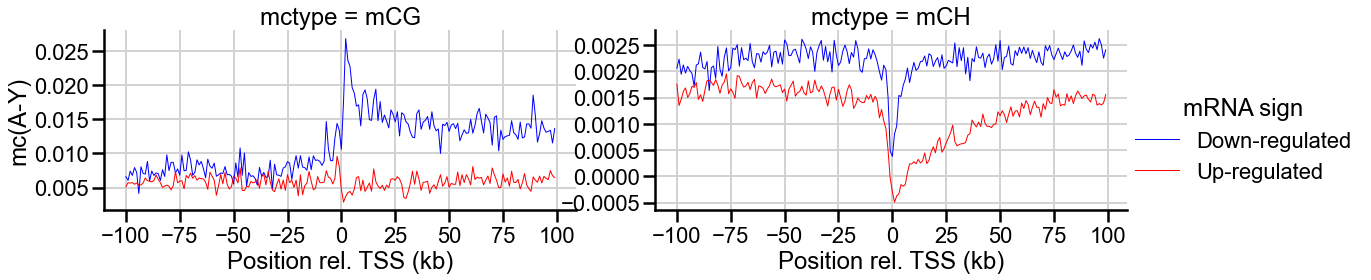

In [6]:
%%time
# Calculate mC difference (A-Y) in bins
cols=df_binc.columns.to_frame()
cols['age']=cols['donor'].str[0].values
df_bincu = df_binc.copy()
df_bincu.columns = pd.MultiIndex.from_frame(cols)
df_bincu=df_bincu.groupby(['age','celltype','mCtype'],axis=1).median()
df_bincu=df_bincu['A']-df_bincu['Y']

df_bincu.index.names=['gene','bin']
df_bincu=df_bincu.stack('celltype').reorder_levels(['celltype','gene','bin'],axis=0)

df_bincu=df_bincu.unstack('bin')
data_tmp=data.reset_index().rename(columns={'index':'gene'}).set_index(['celltype','gene'])
df_bincu.loc[data_tmp.index]
df_bincu=df_bincu.stack('bin')

dfuu=df_bincu.join(data_tmp[['logFC']],how='inner')
dfuu=dfuu.reset_index()

dfuu = dfuu.set_index(['celltype','gene','bin','logFC'])[['mCG','mCH']]
dfuu.columns.name = 'mctype'

dfuu = dfuu.stack().rename('mc(A-Y)')
dfuu = dfuu.reset_index()

dfuu['Position rel. TSS (kb)']=dfuu['bin']/1000
dfuu['mRNA sign'] = (dfuu['logFC']>0).map({True:'Up-regulated',False:'Down-regulated'})

with sns.plotting_context("poster"):
    g=sns.relplot(dfuu,
                kind='line',
                x='Position rel. TSS (kb)',y='mc(A-Y)',
                col='mctype',
                hue='mRNA sign',
                palette={'Up-regulated':'r','Down-regulated':'b'},
                estimator='mean',errorbar=None,
                height=4,aspect=2,linewidth=1,
                facet_kws={'sharey':False},
               )
    for ax in g.axes.flatten():
        ax.grid()

# age-DMRs around age-DEGs

In [7]:
%%time
def profile_bins(genes,dmrs,bins):
  # Make histogram of dmrs around genes
    dmrs['center']=(dmrs['start']+dmrs['end'])/2
    genes['TSS'] = genes['start']
    genes.loc[genes['strand']=='-','TSS']=genes.loc[genes['strand']=='-','end']
    dmrs['direction']=(dmrs['areaStat']>0).map({False:'hypo',True:'hyper'})
  
    df_dmrs_bins={}
    for rna_direction in ['Up-regulated','Down-regulated']:
        if rna_direction=='Up-regulated':
            genesu=genes[genes['logFC']>0]
        else:
            genesu=genes[genes['logFC']<0]
      
        for dmr_direction in ['hyper','hypo']:
            dmrs_bins=[]
            for _,g in genesu.iterrows():
                dmrsu=dmrs[(dmrs['chr']==g['chr'])&(dmrs['direction']==dmr_direction)&(dmrs['celltype']==g['celltype'])]
                if g['strand']=='+':
                    myhist,bins = np.histogram(dmrsu['center']-g['TSS'],bins=bins)
                else:
                    myhist,bins = np.histogram(-(dmrsu['center']-g['TSS']),bins=bins)
                dmrs_bins.append(myhist)
            dmrs_bins=np.stack(dmrs_bins)
            dmrs_bins=pd.DataFrame(dmrs_bins,index=genesu.index,columns=bins[:-1])
            dmrs_bins.columns.name='bins'
            df_dmrs_bins[(dmr_direction,rna_direction)]=dmrs_bins.mean(axis=0)
    df_dmrs_bins=pd.concat(df_dmrs_bins,names=['DMR direction','RNA change'])
  
    binsize=np.median(np.diff(bins))
    df_dmrs_bins /= (binsize/1000)
    df_dmrs_bins=df_dmrs_bins.rename('DMRs per gene per kb').reset_index()
    return df_dmrs_bins


binsize=1e3
bins=np.arange(-1e5,1e5,binsize)
df_dmrs_bins = profile_bins(data,df_dmrs,bins)
df_dmrs_bins['Position rel. TSS (kb)']=(np.floor(df_dmrs_bins['bins']/binsize)*binsize)/1000
df_dmrs_bins['hue']=df_dmrs_bins['RNA change']+'-'+df_dmrs_bins['DMR direction']

CPU times: user 1min 2s, sys: 36.6 ms, total: 1min 2s
Wall time: 1min 2s


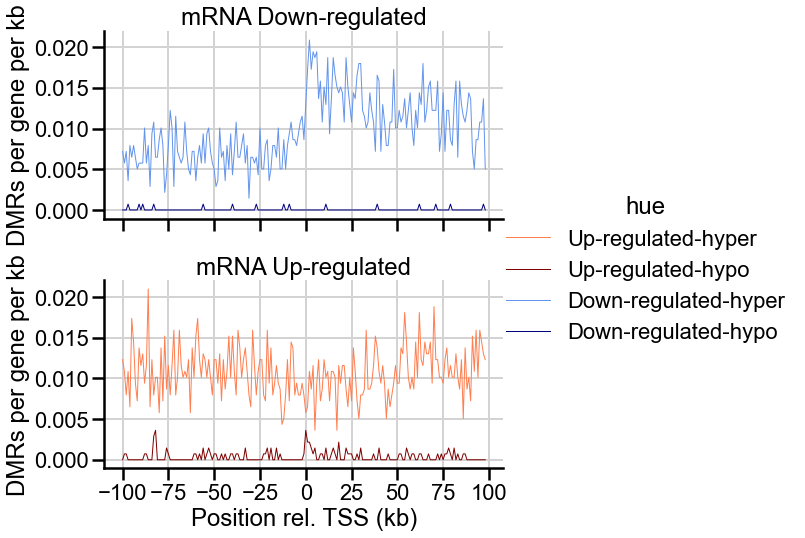

In [8]:
with sns.plotting_context("poster"):
    g=sns.relplot(df_dmrs_bins,
                    kind='line',
                    x='Position rel. TSS (kb)',y='DMRs per gene per kb',
                    row='RNA change',row_order=['Down-regulated','Up-regulated'],
                    hue='hue',
                    palette={'Up-regulated-hyper':'coral', 'Up-regulated-hypo':'maroon',
                           'Down-regulated-hyper':'cornflowerblue','Down-regulated-hypo':'navy'},
                    estimator='mean',errorbar=None,
                    height=4,aspect=2,linewidth=1,
                    facet_kws={'sharey':True}
                )
    g.set_titles(template='mRNA {row_name}')
    for ax in g.axes.flatten():
        ax.grid()

# subtelomere property

In [9]:
binsize=1e6
hg38=pd.read_csv('../data/hg38.genome.size',sep='\t',names=['chr','length'],index_col='chr')
hg38=hg38.loc[[f'chr{i+1}' for i in range(22)]+['chrX'],:]
hg38['length_mbp']=hg38['length']/1e6
chroms=[f'chr{i+1}' for i in range(22)]+['chrX']
chrom_nums={chr:i for i,chr in enumerate(chroms)}

centromeres=pd.read_csv('https://hgdownload.soe.ucsc.edu/goldenPath/hg38/database/centromeres.txt.gz',sep='\t',names=['-','chr','start','end','id'])
gencode = pd.read_csv('../data/gencode.v37.annotation.intragenic.bed.gz',sep='\t',
                      names=['chr','start','end','gene_id','strand','-','gene_name','gene_type'],index_col='gene_id')
gencode = gencode[gencode['gene_type'].isin(['protein_coding','lncRNA'])]

# DEs
fcthres = np.log2(1.2)
pthres = 0.05
fulldata = pd.read_csv('../data/ageDEall.tsv.gz',sep='\t',index_col=0)
fulldata = fulldata[fulldata['celltype'].isin(cziplot.level2_order)]
fulldata=fulldata.join(gene_meta[['chr','start','end','strand']])
data = fulldata[(fulldata['adj.P.Val']<pthres) & (np.abs(fulldata['logFC'])>fcthres)]
degs = data.copy()
degs.index.name = 'Gene'
degs = degs.rename(columns={'chrom':'chr'})
degs['direction'] = (degs['logFC']>0).map({False:'Y>A',True:'A>Y'})

#DMRs
age_dmrs = pd.read_csv('../data/ageDMRall.tsv.gz',sep='\t')
age_dmrs['sign']=(age_dmrs['areaStat']>0).map({True:'hyper',False:'hypo'})

In [10]:
def ideogram(dmrs,binsize=1e6,cbar_label='Num. DEGs per Mbp',**kwargs):
  # Plot an ideogram showing all the chromosomes
    chroms=[f'chr{i+1}' for i in range(22)]+['chrX']
    chroms=chroms[::-1]
    dmrs=dmrs.copy()
    dmrs['center']=(dmrs['start']+dmrs['end'])/2
    dmrs['center_binned'] = np.floor(dmrs['center']/binsize)*binsize/1e6
    bins = (np.floor(np.arange(0,250e6,binsize)/binsize)*binsize/1e6).astype(float)
    dmrs['center_binned']=pd.Categorical(dmrs['center_binned'],categories=bins,ordered=True)
    dmrs['chr']=pd.Categorical(dmrs['chr'],categories=chroms,ordered=True)

    dmrs_hist = dmrs.groupby(['chr','center_binned'])['start'].count()
    dmrs_hist=dmrs_hist.unstack().fillna(0)
  
    cmap=plt.cm.Reds.copy()
    cmap.set_bad('white')
    ax=sns.heatmap(dmrs_hist,
                cmap=cmap,
                vmin=0,
                vmax=dmrs_hist.iloc[:-1].quantile(.95).max(),
                cbar_kws={'shrink':.5,'label':cbar_label,
                        'location':'left',
                        },
                 mask=dmrs_hist==0,
                 yticklabels=True,
                **kwargs)
    ax.set_xlabel('Position (Mbp)')
    ax.set_xticks(np.arange(0,300,50)*1e6/binsize,labels=np.arange(0,300,50))
    hg38['length_mbp']=hg38['length']/1e6
    ax.barh(y=np.arange(len(chroms))+0.5,
          width=np.ceil(hg38.loc[chroms,'length']/binsize),
           height=1,color=(0,0,0,0),edgecolor='k'
          )
    ax.set_ylabel('')
    for ichrom,chrom in enumerate(chroms):
        cu = centromeres[centromeres['chr']==chrom]
        for i in range(cu.shape[0]):
            ax.plot(cu.iloc[i][['start','end']]/binsize, [ichrom+.5,ichrom+.5], 'kd-',markersize=2)
    return dmrs_hist

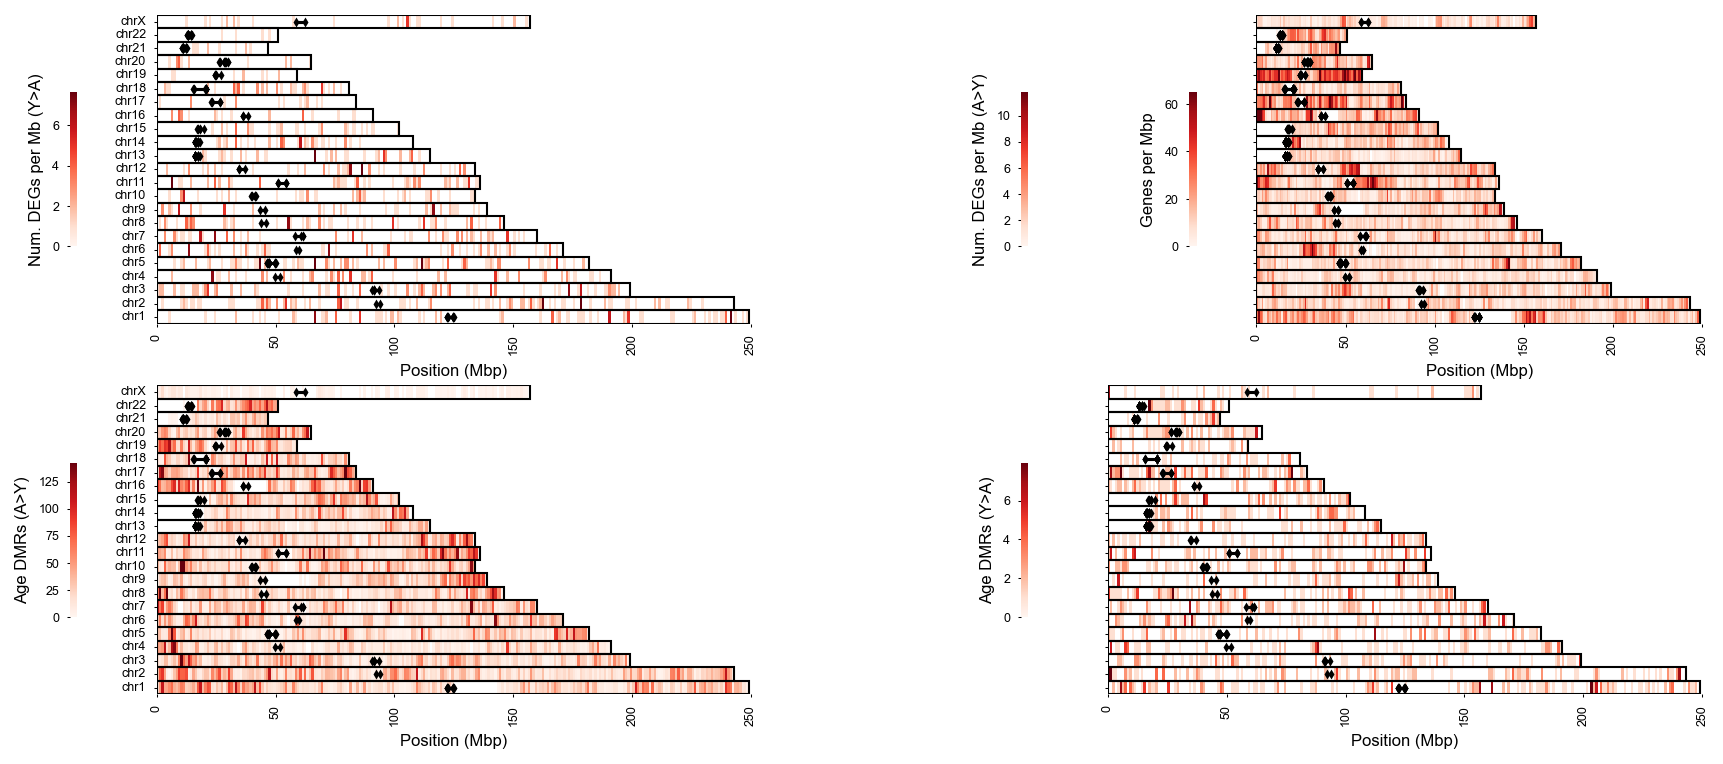

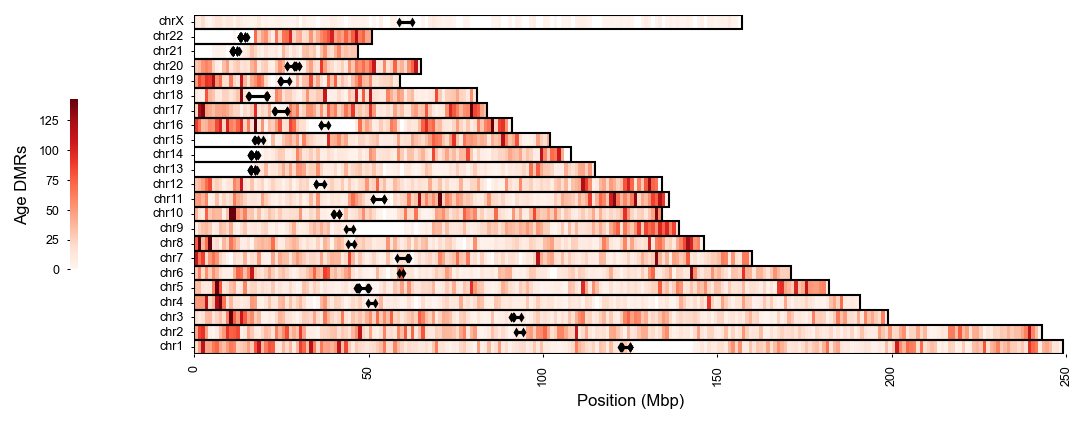

In [11]:
fig,axs=plt.subplots(2,2,figsize=(15,6),sharex=False,sharey=True,dpi=dpi)
axs=axs.flatten()
degs_hist={}
for ax,direction in zip(axs,['Y>A','A>Y']):
    degs_hist[direction]=ideogram(degs[degs['direction']==direction],
                     ax=ax,
                     binsize=binsize,
                     cbar_label=f'Num. DEGs per Mb ({direction})'
                    )
degs_hist['age_dmrs_hyper']=ideogram(age_dmrs[age_dmrs['areaStat']>0],ax=axs[len(degs_hist)],cbar_label='Age DMRs (A>Y)',binsize=binsize)
degs_hist['age_dmrs_hypo']=ideogram(age_dmrs[age_dmrs['areaStat']<0],ax=axs[len(degs_hist)],cbar_label='Age DMRs (Y>A)',binsize=binsize)
degs_hist['genes']=ideogram(gencode,ax=ax,cbar_label='Genes per Mbp',binsize=binsize);
plt.figure(figsize=(10,3),dpi=dpi)
_=ideogram(age_dmrs,cbar_label='Age DMRs',binsize=binsize)

In [12]:
! gdown -O /scratch/hg38.bedtools_pctgc.100kb_bins.bed.gz  https://drive.google.com/file/d/1dNtUMzZT4KzIyXzjc9YQZjnVf9h0WFlc/view?usp=drive_link --fuzzy 
gc_content = pd.read_csv('/scratch/hg38.bedtools_pctgc.100kb_bins.bed.gz',sep='\t')
gc_content['center_binned'] = np.floor((gc_content['start']+gc_content['end'])/2/binsize)*binsize/1e6
gc_content['center_binned'] = pd.Categorical(gc_content['center_binned'],categories=degs_hist['genes'].columns.categories,ordered=True)
gc_content = gc_content.groupby(['chr','center_binned'])['pct_gc'].mean().unstack()

Downloading...
From: https://drive.google.com/uc?id=1dNtUMzZT4KzIyXzjc9YQZjnVf9h0WFlc
To: /scratch/hg38.bedtools_pctgc.100kb_bins.bed.gz
100%|████████████████████████████████████████| 212k/212k [00:00<00:00, 56.4MB/s]


In [13]:
# average mC level
# ! gdown -O /scratch/binc_CelltypesDonors_binsize1kb.tsv.gz  https://drive.google.com/file/d/1oHuKOOci0pEjoprB5E6a28vD9F-qVxym/view?usp=sharing --fuzzy
mc_bins=pd.read_csv('/scratch/binc_CelltypesDonors_binsize1kb.tsv.gz',sep='\t',header=[0,1,2,3],index_col=[0,1])
mc_cols = mc_bins.columns.to_frame()
mc_cols['demo']=mc_cols['donor'].str[0]+mc_cols['donor'].str[1]
mc_bins.columns = pd.MultiIndex.from_frame(mc_cols[['celltype','demo','mCtype']])
mc_bins = mc_bins.groupby(level=['celltype','demo','mCtype'],axis=1).mean()
mc_bins=mc_bins.sort_index(axis=1)
mc_bins=mc_bins.stack(['mCtype','celltype','demo']).rename('value')
mc_bins=mc_bins.reset_index()
mc_bins=mc_bins.merge(hg38[['length']],on='chr')
# binsize=5e5
mc_bins['Distance from chr end'] = np.minimum(mc_bins['length']-mc_bins['bin'], mc_bins['bin'])/1e6
mc_bins['Distance from chr end']=np.floor(mc_bins['Distance from chr end']*1e6/binsize)*binsize/1e6

mc_bins_mean=mc_bins.groupby(['mCtype','celltype','demo','Distance from chr end'])['value'].mean()
mc_mean = mc_bins.groupby(['mCtype','celltype','demo'])['value'].mean()
mc_bins_norm = (mc_bins_mean / mc_mean).reset_index()
mc_bins_norm=mc_bins_norm[mc_bins_norm['Distance from chr end']<30]

Text(0.5, 1, 'Errorbar=SD')

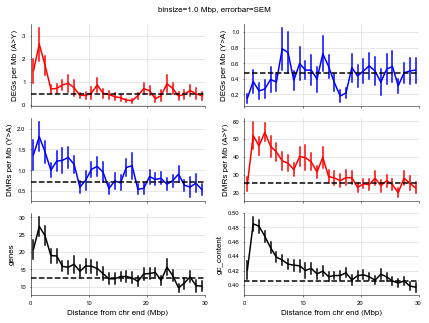

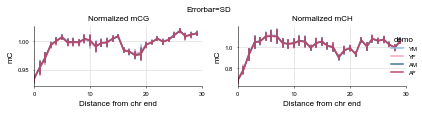

In [14]:
df_show = gc_content.stack().rename('gc_content').to_frame()
badbins=df_show['gc_content']==0

df_show=df_show.join(degs_hist['genes'].stack().rename('genes'))
df_show=df_show.join(degs_hist['A>Y'].stack().rename('DEGs per Mb (A>Y)'))
df_show=df_show.join(degs_hist['Y>A'].stack().rename('DEGs per Mb (Y>A)'))
df_show=df_show.join(degs_hist['age_dmrs_hyper'].stack().rename('DMRs per Mb (A>Y)'))
df_show=df_show.join(degs_hist['age_dmrs_hypo'].stack().rename('DMRs per Mb (Y>A)'))
df_show=df_show.reset_index().merge(hg38[['length_mbp']],on='chr')
df_show['Distance from chr end'] = np.minimum(df_show['length_mbp']-df_show['center_binned'].astype(float), df_show['center_binned'].astype(float))
df_show['Distance from chr end'] = np.floor(df_show['Distance from chr end']*1e6/binsize)*binsize/1e6

df_show=df_show.set_index(['chr','center_binned','Distance from chr end']).drop(columns=['length_mbp'])
df_show.columns.name='stat'
df_show=df_show.stack().rename('value').reset_index()
df_show=df_show.sort_values('Distance from chr end',ascending=False)
df_show['direction']=df_show['stat'].str.extract(r'\((.*)\)').fillna('-')
df_show['Distance from chr end'] += binsize/2/1e6

df_show=df_show.set_index(['chr','center_binned'])
df_show.loc[badbins,'value']=np.nan
df_show=df_show.reset_index()

df_show_mean=df_show.groupby(['stat'])['value'].mean()

df_show = df_show[df_show['Distance from chr end']<30]

g=sns.relplot(data=df_show,kind='line',
              x='Distance from chr end',y='value',
              col='stat',col_wrap=2,col_order=[
                                               'DEGs per Mb (A>Y)', 'DEGs per Mb (Y>A)',
                                               'DMRs per Mb (Y>A)','DMRs per Mb (A>Y)',
                                               'genes','gc_content',
                                              ],
              facet_kws={'sharey':False},
              hue='direction',palette={'Y>A':'b','A>Y':'r','-':'k','F>M':'coral','M>F':'darkgreen','F>M chrX':'coral','M>F chrX':'darkgreen'},
              height=1.5,aspect=2,
              estimator='mean',
              errorbar='se',
              err_style='bars',
              legend=False,
              markers=True
            )
g.set(xticks=[0,10,20,30],xlim=[0,30])
g.set(xlabel='Distance from chr end (Mbp)')
g.set_titles(template='')

for key in g.axes_dict:
    ax=g.axes_dict[key]
    ax.hlines(df_show_mean.loc[key],0,30,'k',linestyle='--')
    ax.grid()
    ax.set_ylabel(key)
g.fig.suptitle(f'binsize={binsize/1e6} Mbp, errorbar=SEM')
g.fig.tight_layout()

g=sns.relplot(mc_bins_norm,kind='line',
            x='Distance from chr end',y='value',
            col='mCtype',
            hue='demo',palette=cziplot.demo_palette,hue_order=cziplot.demo_order,
            height=1.5,aspect=1.8,
            facet_kws={'sharey':'col',
                       'margin_titles':False},
            estimator='mean',errorbar='sd',err_style='bars',
           )
for ax in g.axes.flatten():
    ax.grid()
g.set(xticks=[0,10,20,30],xlim=[0,30])
g.set_titles(template='Normalized {col_name}')
g.set(ylabel='mC')
g.fig.tight_layout()
g.fig.suptitle('Errorbar=SD',y=1)

# telomere length

L2-4IT_CUX2
age stat: RanksumsResult(statistic=-2.1908902300206643, pvalue=0.028459736916310565)
sex stat: RanksumsResult(statistic=0.3651483716701107, pvalue=0.7150006546880893)


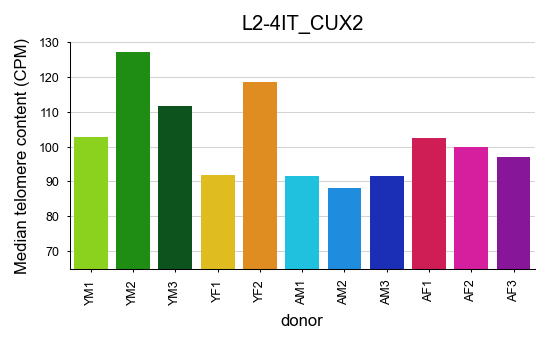

In [15]:
telomeres=pd.read_csv('../data/telomerehunter.tsv.gz',sep='\t',index_col=0)
telomeres['tel_CPM'] = 1e6*telomeres['intratel_reads']/telomeres['FinalDNAReads']

celltype='L2-4IT_CUX2'
df=telomeres[telomeres['level2']==celltype].groupby('donor')[['tel_CPM']].median()
df['age']=df.index.str[0].map({'A':'Aged','Y':'Young'})
df['sex']=df.index.str[1]
df['donor']=df.index
df=df.loc[cziplot.donor_order]

plt.figure(figsize=(4,2),dpi=dpi)
sns.barplot(data=df,x='donor',y='tel_CPM',palette=cziplot.donor_palette)
plt.ylim(65,130)
plt.grid(axis='y')
plt.ylabel('Median telomere content (CPM)')
plt.xticks(rotation=90)
plt.title(celltype)

print(celltype)
print('age stat:',sc.stats.ranksums(df[df['age']=='Aged']['tel_CPM'],df[df['age']=='Young']['tel_CPM']))
print('sex stat:',sc.stats.ranksums(df[df['sex']=='F']['tel_CPM'],df[df['sex']=='M']['tel_CPM']))

# association with DEGs

Downloading...
From: https://drive.google.com/uc?id=12qM2_jf1mnInTGGL79GuhTqI22YEVIhf
To: /scratch/L2-4IT_CUX2_combinesample_log2cpm+1.tsv.gz
100%|██████████████████████████████████████| 3.18M/3.18M [00:00<00:00, 21.9MB/s]


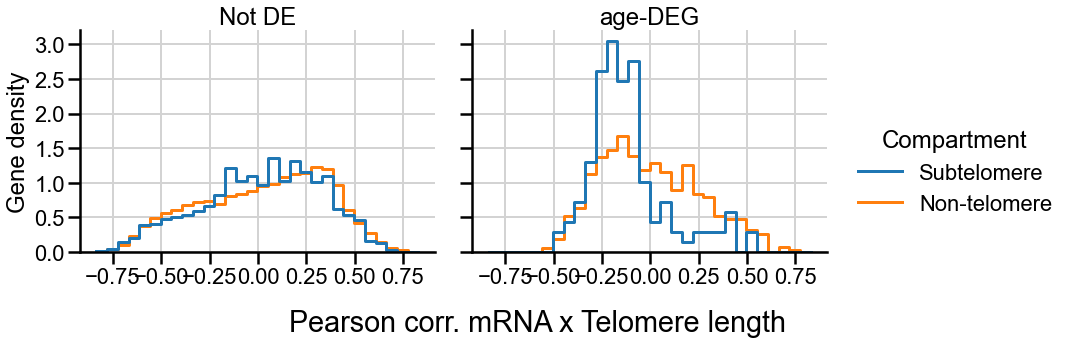

In [16]:
hg38=pd.read_csv('../data/hg38.genome.size',sep='\t',names=['chr','length'],index_col='chr')
hg38=hg38.loc[[f'chr{i+1}' for i in range(22)],:]
hg38['length_mbp']=hg38['length']/1e6

fcthres=np.log2(1.2)
pthres=0.05
fulldata=pd.read_csv('../data/ageDEall.tsv.gz',sep='\t',index_col=0)

! gdown -O /scratch/L2-4IT_CUX2_combinesample_log2cpm+1.tsv.gz https://drive.google.com/file/d/12qM2_jf1mnInTGGL79GuhTqI22YEVIhf/view?usp=drive_link --fuzzy
celltype='L2-4IT_CUX2'
rna=pd.read_csv(f'/scratch/{celltype}_combinesample_log2cpm+1.tsv.gz',sep='\t',header=[0],index_col=0)
rnau = rna.T
rnau_zscore = rnau-rnau.mean(axis=0)
rnau_zscore /= rnau.std(axis=0)

telomeres['age']=telomeres['donor'].str[0]
telomeres['sex']=telomeres['donor'].str[1]
telomeres_avg = telomeres[telomeres['sample'].isin(cziplot.sample_order_rna)].groupby(['donor','age','sex','level2'])['tel_CPM'].median().reset_index()
telu=telomeres_avg[telomeres_avg['level2']==celltype]
telu=telu.set_index('donor')[['tel_CPM']]
telu_zscore =  telu['tel_CPM']
telu_zscore = telu_zscore-telu_zscore.mean()
telu_zscore /= telu_zscore.std()

rnau_zscore,telu_zscore = rnau_zscore.align(telu_zscore,axis=0,join='inner')
nsamples=rnau_zscore.shape[0]

cc=rnau_zscore.T.dot(telu_zscore)/nsamples
cc_shuffstats=pd.DataFrame()
cc_shuffstats['cc']=cc
cc_shuffstats=cc_shuffstats.join(gene_meta,how='inner')

cc_shuffstats=cc_shuffstats.reset_index().merge(hg38,on='chr',how='inner')
cc_shuffstats=cc_shuffstats.rename(columns={'index':'gene_id'})

cc_shuffstats['tss']=cc_shuffstats['start']
cc_shuffstats.loc[cc_shuffstats['strand']=='-','tss']=cc_shuffstats.loc[cc_shuffstats['strand']=='-','end']
cc_shuffstats['Distance from chr end'] = np.minimum(cc_shuffstats['length']-cc_shuffstats['tss'].astype(float), cc_shuffstats['tss'].astype(float))
cc_shuffstats['Distance from chr end']/=1e6
cc_shuffstats['Compartment'] = (cc_shuffstats['Distance from chr end']<=5).map({True:'Subtelomere',False:'Non-telomere'})

binsize=1 # in Mbp
cc_shuffstats['Distance from chr end'] = np.floor(cc_shuffstats['Distance from chr end']/binsize)*binsize
cc_shuffstats['Distance from chr end'] = cc_shuffstats['Distance from chr end'].clip(0,15)
cc_shuffstats['Distance from chr end'] += binsize/2
   
age_degs=fulldata[(fulldata['celltype']==celltype)]
age_degs['direction'] = (age_degs['logFC']>0).map({False:'Y>A',True:'A>Y'})
cc_degs=cc_shuffstats.merge(age_degs,how='inner',left_on='gene_id',right_index=True)#,how='left'
cc_degs['DE'] = (((cc_degs['adj.P.Val']<pthres)&(np.abs(cc_degs['logFC']))>fcthres)).map({True:'age-DEG',False:'Not DE'})

with sns.plotting_context("poster"):
    g=sns.displot(cc_degs,kind='hist',x='cc',
                hue='Compartment',
                col='DE',
                  bins=30,
                stat='density',
                  common_norm=False,common_bins=True,
                height=5,aspect=1.2,
                  fill=False,element='step',
               )
    g.set_titles(template='{col_name}')
    for ax in g.axes.flatten():
      ax.grid()
      ax.set_xlabel('')
      ax.set_ylabel('Gene density')
    g.fig.supxlabel('Pearson corr. mRNA x Telomere length')

# enrichment of DEGs in subtelomere

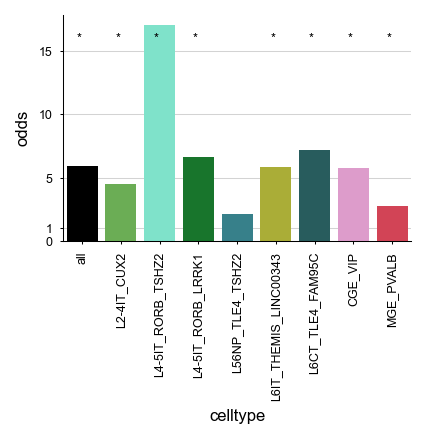

In [17]:
level2_palette_tmp=level2_palette.copy()
level2_palette_tmp.update({'all':'k'})

hg38=pd.read_csv('../data/hg38.genome.size',sep='\t',names=['chr','length'],index_col='chr')
hg38=hg38.loc[[f'chr{i+1}' for i in range(22)],:]
hg38['length_mbp']=hg38['length']/1e6

fcthres=np.log2(1.2)
pthres=0.05
fulldata=pd.read_csv('../data/ageDEall.tsv.gz',sep='\t',index_col=0)

level2_order_tmp=['all', 'L2-4IT_CUX2', 'L4-5IT_RORB_TSHZ2', 'L4-5IT_RORB_LRRK1', 'L56NP_TLE4_TSHZ2',
 'L6IT_THEMIS_LINC00343', 'L6CT_TLE4_FAM95C', 'CGE_VIP', 'MGE_PVALB'] #>100DEGs
enrich=[]
for celltype in level2_order_tmp:
    if celltype =='all':
        age_degs=fulldata.copy()
    else:
        age_degs=fulldata[(fulldata['celltype']==celltype)]

    age_degs['direction'] = (age_degs['logFC']>0).map({False:'Y>A',True:'A>Y'})
    cc_degs=cc_shuffstats.merge(age_degs,how='left',left_on='gene_id',right_index=True)#,how='left'
    cc_degs['DE'] = (((cc_degs['adj.P.Val']<pthres)&(np.abs(cc_degs['logFC']))>fcthres)).map({True:'age-DEG',False:'Not DE'})
    cc_degs=cc_degs[cc_degs['DE']=='age-DEG']
    if len(cc_degs)>0:
        degsu=cc_degs.groupby(['Compartment','direction']).size().unstack(['direction']).fillna(0)
        if len(degsu.index)>1:
            pcount = 1
            degsu['ratio'] = (degsu['A>Y']+pcount)/(degsu['Y>A']+pcount)
            ratio=degsu.loc['Subtelomere']['ratio']/degsu.loc['Non-telomere']['ratio']
            odds,p=sc.stats.fisher_exact(degsu.loc[['Subtelomere','Non-telomere'],['A>Y','Y>A']], alternative='two-sided')
            enrich.append([celltype,ratio,p])
    else:
        enrich.append([celltype,0,1])
enrich=pd.DataFrame(enrich)
enrich.columns=['celltype','odds','p']
_,enrich['fdr']=fdrcorrection(enrich['p'])

plt.figure(figsize=(3,2),dpi=150)
barplot = sns.barplot(data=enrich,x='celltype',y='odds',order=level2_order_tmp,palette=level2_palette_tmp)
enrich['sig']=''
enrich.loc[enrich['fdr']<0.05,'sig']=True
enrich['celltype'] = pd.Categorical(enrich['celltype'] , level2_order_tmp)
sig_sorted=enrich.sort_values('celltype').reset_index(drop=True)['sig'].values
for p,sig in zip(barplot.patches,sig_sorted):
    if sig == True:
        barplot.annotate('*', (p.get_x() + p.get_width()/2.5, 16),
                    ha='center', va='center', fontsize=6, color='black')

plt.xticks(rotation=90)
plt.yticks([0,1,5,10,15])
plt.grid(axis='y')